# Sentiment analysis with Word2Vec

### Notebook objectives:
- Convert words to vectors with Word2Vec
- Use the word representation given by Word2vec to feed a RNN

<hr>
<hr>


# The data


Let's first load the data

⚠️ **Warning** ⚠️ The `load_data` function has a `percentage_of_sentences` argument. Depending on your computer, there are chances that too many sentences will make your compute slow down, or even freeze - your RAM can overflow. For that reason, **you should start with 10% of the sentences** and see if your computer handles it. Otherwise, rerun with a lower number. 


In [187]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/NLPmoviereviews/')

from NLPmoviereviews.data import load_data

X_train, y_train, X_test, y_test = load_data(percentage_of_sentences=10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Baseline model

It is always good to have a very simple model to test your own model against - to be sure you are doing something better than a very simple algorithm.

Our baseline can be to predict the label that is the most present in `y_train` (of course, if the dataset is balanced, the baseline accuracy is 1/n where n is the number of classes - 2 here).

In [188]:
import pandas as pd
pd.Series(y_test).value_counts()

1    1270
0    1230
dtype: int64

In [3]:
baseline_accuracy=1/2
print(f'Baseline accuracy on the test set : {baseline_accuracy:.2f}')

Baseline accuracy on the test set : 0.50


# Trained Word2Vec - Transfer Learning


List all the different models available in the word2vec: 

In [177]:
from gensim.models import Word2Vec
import gensim.downloader as api
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Load one of the pre-trained word2vec embedding spaces. 
    
The `glove-wiki-gigaword-50` model is a good candidate to start with as it is smaller (65 MB).


In [178]:
word2vec_transfer=api.load('glove-wiki-gigaword-100')

Check the size of the vocabulary, but also the size of the embedding space.

Embed `X_train` and `X_test`

In [179]:
import numpy as np
from NLPmoviereviews.utilities import padding

In [189]:
X_train_pad = padding(word2vec_transfer, X_train, maxlen=200)
X_test_pad = padding(word2vec_transfer, X_test, maxlen=200)

In [190]:
X_train_pad.shape, y_train.shape, X_test_pad.shape, y_test.shape

((2500, 200, 100), (2500,), (2500, 200, 100), (2500,))

☝️ To be sure that it worked, let's check the following for `X_train_pad` and `X_test_pad`:
- they are numpy arrays
- they are 3-dimensional
- the last dimension is of the size of your word2vec embedding space (you can get it with `word2vec.wv.vector_size`
- the first dimension is of the size of your `X_train` and `X_test`

In [191]:
# TEST
for X in [X_train_pad, X_test_pad]:
    assert type(X) == np.ndarray
    assert X.shape[-1] == word2vec_transfer.vector_size


assert X_train_pad.shape[0] == len(X_train)
assert X_test_pad.shape[0] == len(X_test)

Initialize a model and fit it on the embedded (and padded) data!  Evaluate it on the test set and compare it to baseline accuracy.

# RNN model implementation


### let's create a Bidirectional LSTM RNN model:

In [197]:
from tensorflow.keras import models,layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam

if 'model' in globals():
    del model

model=models.Sequential()
model.add(layers.Masking(mask_value=0, input_shape=(200,100)))
model.add(layers.Bidirectional(layers.LSTM(200, 
                                           activation='tanh')))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

In [198]:
es = EarlyStopping(patience=15,restore_best_weights=True, verbose=1)

# Fit the model on the train data
history = model.fit(X_train_pad, y_train,
                    validation_split=0.2,
                    epochs = 180,
                    batch_size = 64, 
                    verbose = 0, 
                    callbacks = [es])

Restoring model weights from the end of the best epoch: 125.
Epoch 140: early stopping


### Let's check the accuracy on test data:

In [199]:
res = model.evaluate(X_test_pad, y_test, verbose=0)
print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

The accuracy evaluated on the test set is of 78.240%


 ### And plot fitting curves:

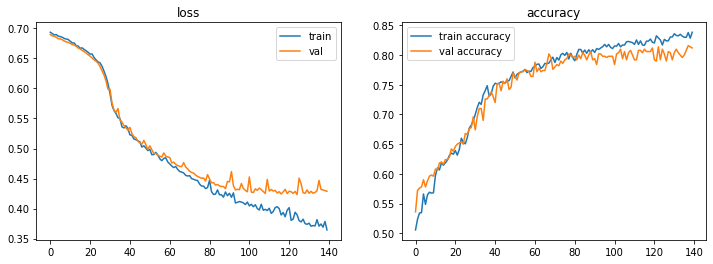

In [200]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['loss'], label = 'train')
ax1.plot(history.history['val_loss'], label = 'val')
#ax1.set_ylim(0., 0.5)
ax1.set_title('loss')
ax1.legend()

ax2.plot(history.history['accuracy'],
          label='train accuracy')
ax2.plot(history.history['val_accuracy'],
          label='val accuracy')
#ax2.set_ylim(0., 0.015)
ax2.set_title('accuracy')
ax2.legend()

# RNN model optimized with Cyclical Learning Rates

In [11]:
from CLR.clr_callback import CyclicLR
from LRF.lr_finder_keras import LRFinder

### Now we can use the entire dataset because of the speed of CLR fitting:

In [210]:
X_train, y_train, X_test, y_test = load_data(percentage_of_sentences=100)
X_train_pad = padding(word2vec_transfer, X_train, maxlen=200)
X_test_pad = padding(word2vec_transfer, X_test, maxlen=200)

### We look for the best learning rate range:

Epoch 1/15
  6/196 [..............................] - ETA: 11s - loss: 0.6935 - accuracy: 0.5260

196/196 [==============================] - 21s 60ms/step - loss: 0.6967 - accuracy: 0.5048
Epoch 2/15
196/196 [==============================] - 12s 60ms/step - loss: 0.6969 - accuracy: 0.5076
Epoch 3/15
196/196 [==============================] - 12s 60ms/step - loss: 0.6976 - accuracy: 0.5038
Epoch 4/15
196/196 [==============================] - 12s 60ms/step - loss: 0.6975 - accuracy: 0.5054
Epoch 5/15
196/196 [==============================] - 12s 60ms/step - loss: 0.6970 - accuracy: 0.5056
Epoch 6/15
196/196 [==============================] - 12s 60ms/step - loss: 0.6971 - accuracy: 0.5046
Epoch 7/15
196/196 [==============================] - 12s 59ms/step - loss: 0.6967 - accuracy: 0.5075
Epoch 8/15
196/196 [==============================] - 12s 60ms/step - loss: 0.6963 - accuracy: 0.5062
Epoch 9/15
196/196 [==============================] - 12s 60ms/step - loss: 0.6959 - accuracy: 0.5093
Epoch 10/15
196/196 [==============================] - 12s 60ms/step - loss: 0.6956 - accurac

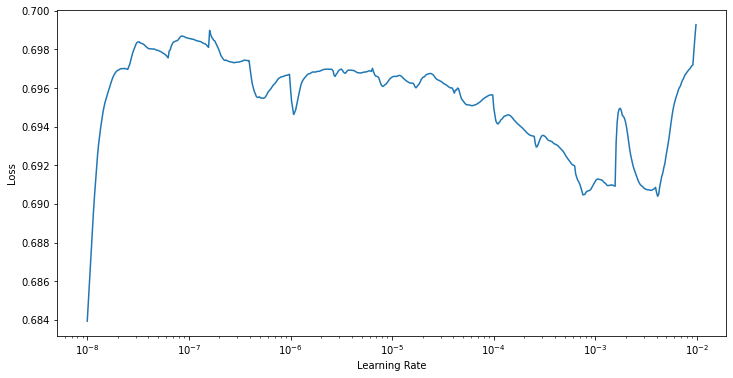

In [211]:
start_lr = 1e-8
end_lr = 1e-2
no_epochs = 15
batch_size = 128
# Define LR finder callback
lr_finder = LRFinder(min_lr=start_lr, max_lr=end_lr)

from tensorflow.keras import models,layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam

if 'model_lrf' in globals():
    del model_lrf

model_lrf=models.Sequential()
model_lrf.add(layers.Masking(mask_value=0, input_shape=(200,100)))
model_lrf.add(layers.Bidirectional(layers.LSTM(200, 
                                           activation='tanh')))
model_lrf.add(layers.Dropout(0.2))
model_lrf.add(layers.Dense(100, activation="relu"))
model_lrf.add(layers.Dense(20, activation="relu"))
model_lrf.add(layers.Dense(1, activation="sigmoid"))

model_lrf.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Perform LR finder
model_lrf.fit(X_train_pad, y_train, batch_size=batch_size, callbacks=[lr_finder], epochs=no_epochs)

### Let's fit the model with the observed range:

In [242]:
if 'model_clr' in globals():
    del model_clr

# Set CLR options
no_epochs = 4
clr_step_size = int(4*(len(X_train_pad)/batch_size))
base_lr = 1e-8
max_lr = 16e-3
mode='triangular'

if 'model_clr' in globals():
    del model_clr
    del history_clr

model_clr=models.Sequential()
model_clr.add(layers.Masking(mask_value=0, input_shape=(200,100)))
model_clr.add(layers.Bidirectional(layers.LSTM(200, 
                                           activation='tanh')))
model_clr.add(layers.Dropout(0.2))
model_clr.add(layers.Dense(100, activation="relu"))
model_clr.add(layers.Dense(20, activation="relu"))
model_clr.add(layers.Dense(1, activation="sigmoid"))

clr = CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=clr_step_size, mode=mode)

# Compile the model
model_clr.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit data to model
history_clr = model_clr.fit(X_train_pad, y_train,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=1,
            validation_split=0.2,
            callbacks=[clr])

Epoch 1/4
157/157 [==============================] - 22s 83ms/step - loss: 0.6616 - accuracy: 0.6036 - val_loss: 0.6054 - val_accuracy: 0.7030
Epoch 2/4
157/157 [==============================] - 10s 63ms/step - loss: 0.5279 - accuracy: 0.7239 - val_loss: 0.3876 - val_accuracy: 0.8354
Epoch 3/4
157/157 [==============================] - 10s 63ms/step - loss: 0.3586 - accuracy: 0.8440 - val_loss: 0.3496 - val_accuracy: 0.8582
Epoch 4/4
157/157 [==============================] - 10s 63ms/step - loss: 0.3137 - accuracy: 0.8677 - val_loss: 0.3234 - val_accuracy: 0.8668


### Let's check the model summary:

In [240]:
model_clr.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_39 (Masking)        (None, 200, 100)          0         
                                                                 
 bidirectional_39 (Bidirecti  (None, 400)              481600    
 onal)                                                           
                                                                 
 dropout_39 (Dropout)        (None, 400)               0         
                                                                 
 dense_117 (Dense)           (None, 100)               40100     
                                                                 
 dense_118 (Dense)           (None, 20)                2020      
                                                                 
 dense_119 (Dense)           (None, 1)                 21        
                                                     

### Let's check the accuracy on test data:

In [244]:
res = model_clr.evaluate(X_test_pad, y_test, verbose=0)
print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

The accuracy evaluated on the test set is of 86.628%


 ### And plot fitting curves:

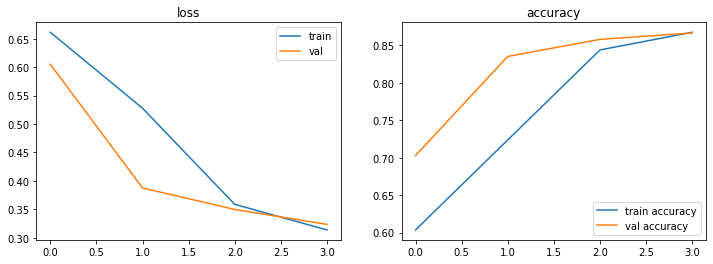

In [243]:
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history_clr.history['loss'], label = 'train')
ax1.plot(history_clr.history['val_loss'], label = 'val')
#ax1.set_ylim(0., 0.5)
ax1.set_title('loss')
ax1.legend()

ax2.plot(history_clr.history['accuracy'],
          label='train accuracy')
ax2.plot(history_clr.history['val_accuracy'],
          label='val accuracy')
#ax2.set_ylim(0., 0.015)
ax2.set_title('accuracy')
ax2.legend()

 ### Let's compare the models with our review:

In [262]:
original_review = "this is really a nice movie, good actors good music good history"

In [263]:
punct = '!"#$%&()*+,./:;<=>?@[\]^_`{|}~'
import string
review = original_review.translate(str.maketrans('', '', punct)).lower()
review = [review.replace('-', ' ').split()]

In [264]:
review_pad = padding(word2vec_transfer, review, maxlen=200)
res = model.predict(review_pad)
res_clr=model_clr.predict(review_pad)
print(f'CLR result: {res_clr[0,0]}, without CLR result: {res[0,0]}')

CLR result: 0.9934313893318176, without CLR result: 0.9596688151359558
